In [94]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import numpy as np 

sys.path.append(os.path.abspath('../helper'))
import utils
import loader
import utils_transfer

sys.path.append('../train/Pix2Pix/helperPix2Pix')
from generator_model import Generator

In [95]:
norm_approach = 'minmax'
lower_range = -1
SNR = -5
idx = 100
device = 'cpu'
# target_data_dir    = "../../CDL Customization/Data/ver39_" 
target_data_dir    = f"../../DeepMIMOv2/DeepMIMO_Data/Static_BS16/freq_symb_1ant_612sub_ver4/Gan_{SNR}_dBOutdoor1_3p4_1ant_612aubcs_Rows3500_3516.mat" 
if SNR in np.arange(0, 31, 5):
    transfer_cnn_model_dir = f"../transfer/transferd_model/static/CNN/ver10_/{SNR}dB"
elif SNR in np.arange(-25, -4, 5):
    transfer_cnn_model_dir = f"../transfer/transferd_model/static/CNN/ver11_/{SNR}dB"
transfer_gan_model_dir = f"../transfer/transferd_model/static/GAN/ver9_/{SNR}dB"

In [96]:
LS_LI_GAN_model = Generator()
LS_GAN_model    = Generator()
LS_LI_CNN_model_ = utils.CNN_Est2(dropOut=0.2, act ='Tanh').to(device)
LS_CNN_model_    = utils.CNN_Est2(dropOut=0, act ='Tanh').to(device)
LS_LI_CNN_model  = utils_transfer.FineTuneModel2(LS_LI_CNN_model_).to(device)
LS_CNN_model  = utils_transfer.FineTuneModel2(LS_CNN_model_).to(device)

checkpoint1 = torch.load(os.path.join(transfer_gan_model_dir, 'LS_LI_GAN_G_model.pth'))
LS_LI_GAN_model.load_state_dict(checkpoint1['model_state_dict'])

checkpoint2 = torch.load(os.path.join(transfer_gan_model_dir, 'LS_GAN_G_model.pth'))
LS_GAN_model.load_state_dict(checkpoint2['model_state_dict'])

checkpoint3 = torch.load(os.path.join(transfer_cnn_model_dir, 'LS_LI_CNN_model.pth'))
LS_LI_CNN_model.load_state_dict(checkpoint3['model_state_dict'])

checkpoint4 = torch.load(os.path.join(transfer_cnn_model_dir, 'LS_CNN_model.pth'))
LS_CNN_model.load_state_dict(checkpoint4['model_state_dict'])

<All keys matched successfully>

In [97]:
train_rate = 0.3
[trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_map_data(target_data_dir, device, SNR, train_rate=train_rate)

print(trainLabels.shape)
print(valLabels.shape)

torch.Size([288, 2, 612, 14])
torch.Size([712, 2, 612, 14])


In [98]:
H_equal_train_normd, H_equal_train_min, H_equal_train_max = utils.minmaxScaler(H_equal_train[idx,:,:,:].unsqueeze(0))
H_equal_val_normd, H_equal_val_min, H_equal_val_max = utils.minmaxScaler(H_equal_val[idx,:,:,:].unsqueeze(0))

H_linear_train_normd, H_linear_train_min, H_linear_train_max = utils.minmaxScaler(H_linear_train[idx,:,:,:].unsqueeze(0))
H_linear_val_normd, H_linear_val_min, H_linear_val_max = utils.minmaxScaler(H_linear_val[idx,:,:,:].unsqueeze(0))

In [99]:
# apply
H_LS_CNN = torch.empty(1, 2, 612, 14)
H_LS_CNN[:,0,:,:] = LS_CNN_model(H_equal_train_normd[0,0,:,:].unsqueeze(0).unsqueeze(0))
H_LS_CNN[:,1,:,:] = LS_CNN_model(H_equal_train_normd[0,1,:,:].unsqueeze(0).unsqueeze(0))

H_LS_LI_CNN = torch.empty(1, 2, 612, 14)
H_LS_LI_CNN[:,0,:,:] = LS_LI_CNN_model(H_linear_train_normd[0,0,:,:].unsqueeze(0).unsqueeze(0))
H_LS_LI_CNN[:,1,:,:] = LS_LI_CNN_model(H_linear_train_normd[0,1,:,:].unsqueeze(0).unsqueeze(0))

H_LS_GAN = torch.empty(1, 2, 612, 14)
H_LS_GAN[:,0,:,:] = LS_GAN_model(H_equal_train_normd[0,0,:,:].unsqueeze(0).unsqueeze(0))
H_LS_GAN[:,1,:,:] = LS_GAN_model(H_equal_train_normd[0,1,:,:].unsqueeze(0).unsqueeze(0))

H_LS_LI_GAN = torch.empty(1, 2, 612, 14)
H_LS_LI_GAN[:,0,:,:] = LS_LI_GAN_model(H_linear_train_normd[0,0,:,:].unsqueeze(0).unsqueeze(0))
H_LS_LI_GAN[:,1,:,:] = LS_LI_GAN_model(H_linear_train_normd[0,1,:,:].unsqueeze(0).unsqueeze(0))


In [100]:
# De-Normalize
H_LS_CNN_denormd = utils.deMinMax(H_LS_CNN, H_equal_train_min, H_equal_train_max)
H_LS_LI_CNN_denormd = utils.deMinMax(H_LS_LI_CNN, H_linear_train_min, H_linear_train_max)

H_LS_GAN_denormd = utils.deMinMax(H_LS_GAN, H_equal_train_min, H_equal_train_max)
H_LS_LI_GAN_denormd = utils.deMinMax(H_LS_LI_GAN, H_linear_train_min, H_linear_train_max)

In [101]:
# calculate NMSE
nmse_LS_LI = utils.calNMSE(H_linear_val[idx,:,:,:].unsqueeze(0), valLabels[idx,:,:,:].unsqueeze(0))

nmse_LS_CNN = utils.calNMSE(H_LS_CNN_denormd, valLabels[idx,:,:,:].unsqueeze(0))
nmse_LS_LI_CNN = utils.calNMSE(H_LS_LI_CNN_denormd, valLabels[idx,:,:,:].unsqueeze(0))
nmse_LS_GAN = utils.calNMSE(H_LS_GAN_denormd, valLabels[idx,:,:,:].unsqueeze(0))
nmse_LS_LI_GAN = utils.calNMSE(H_LS_LI_GAN_denormd, valLabels[idx,:,:,:].unsqueeze(0))

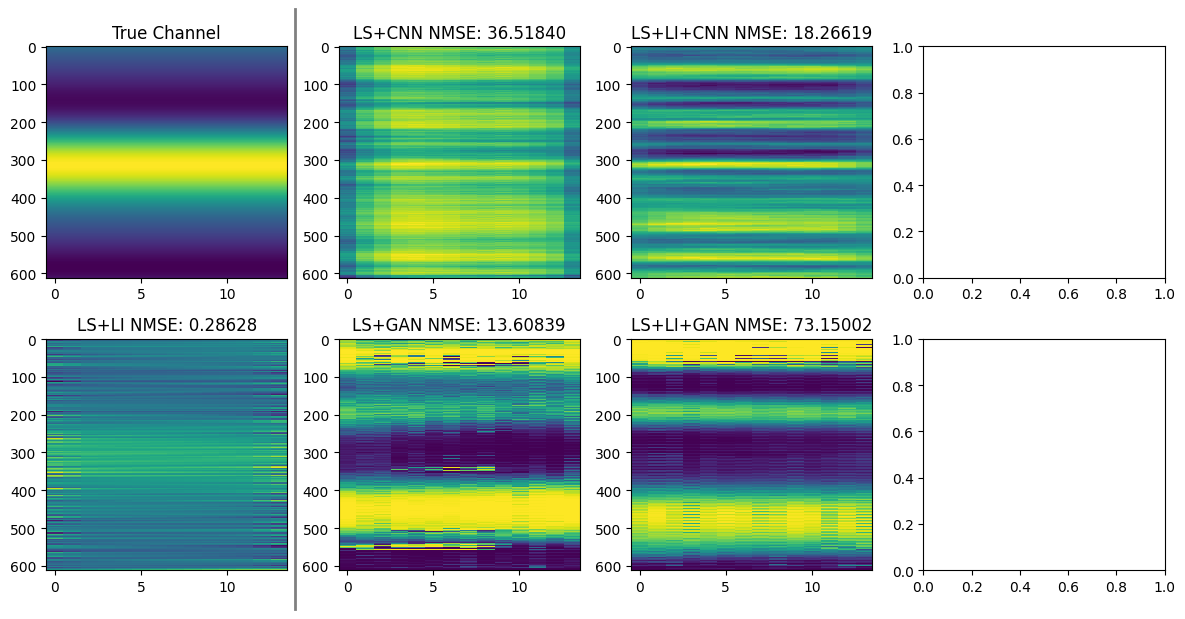

In [102]:
# Generate some example data
x = np.linspace(0, 10, 100)
y = np.sin(x)
i_part = 0

# Create 2x4 subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# True    
axes[0, 0].imshow(valLabels[idx,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[0, 0].set_title('True Channel')
# axes[0, 0].colorbar()

# LS+LI     
axes[1, 0].imshow(H_linear_val[idx,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[1, 0].set_title(f'LS+LI NMSE: {nmse_LS_LI.item():.5f}')
# axes[0, 0].colorbar()


# CNN     
axes[0, 1].imshow(H_LS_CNN_denormd.detach().numpy()[0,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[0, 1].set_title(f'LS+CNN NMSE: {nmse_LS_CNN.item():.5f}')
# axes[0, 0].colorbar()

axes[0, 2].imshow(H_LS_LI_CNN_denormd.detach().numpy()[0,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[0, 2].set_title(f'LS+LI+CNN NMSE: {nmse_LS_LI_CNN.item():.5f}')
# axes[0, 0].colorbar()


# GAN     
axes[1, 1].imshow(H_LS_GAN_denormd.detach().numpy()[0,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[1, 1].set_title(f'LS+GAN NMSE: {nmse_LS_GAN.item():.5f}')
# axes[0, 0].colorbar()

axes[1, 2].imshow(H_LS_LI_GAN_denormd.detach().numpy()[0,i_part,:,:],  aspect='auto', cmap='viridis', interpolation='none')
# axes[0, 0].xlabel('OFDM symbol')
# axes[0, 0].ylabel('Subcarrier')
axes[1, 2].set_title(f'LS+LI+GAN NMSE: {nmse_LS_LI_GAN.item():.5f}')
# axes[0, 0].colorbar()



# Add a vertical line to divide the first and second column
fig.add_artist(plt.Line2D([0.25, 0.25], [0, 1], transform=fig.transFigure, color="gray", linewidth=2))


# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()